# Vision in FRC 

We're going to go over the basic process of using computer vision in FRC contexts to compute location of a target relative to your robot.

The `%matplotlib inline` magic will allow Jupyter to display plots inline. 

In [43]:
%matplotlib inline

These lines import OpenCV (`cv2`) and pyplot (as `plt` for short)

In [44]:
import cv2
import matplotlib.pyplot as plt

## Steps

1. Acquire Image
2. Locate Target
3. Determine Pose Change

## Acquire Image

Now that we have loaded some useful libraries let's actually use them. Since Step 1 is acquiring an image we're going to do just that. You'll notice there's a folder of images located at [images](images/), let's look at a simple one: 

<img src="images/14_00_640.png" />

Let's learn how to load that so OpenCV can find the target.

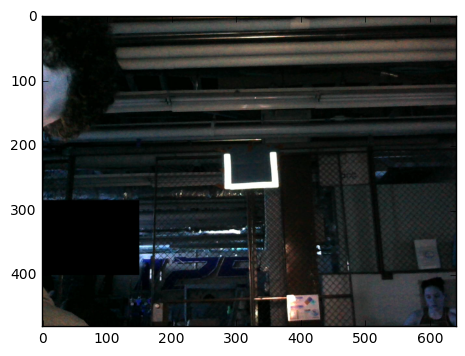

In [45]:
image = cv2.imread("images/14_00_640.png")
plt.imshow(image)

You can see that the image is in fact 640x480 pixels and we can see the target we want is located at about (325, 250) so we should expect whatever processing pipeline we want to make to spit out those numbers. 

## Locate Target

This is the part that gets tricky. It's all about transforming the image such that the target is highly visible and not much else is. We're going to try a few things and then discuss some tricks for finding a pipeline that works. 

### Just Threshold

Optimally, what we want is to get an image that the target is white and everything else is black, why? Because the `findContours` function operates on binary images. So, let's see how close we can get without doing anything more than a threshold operation.

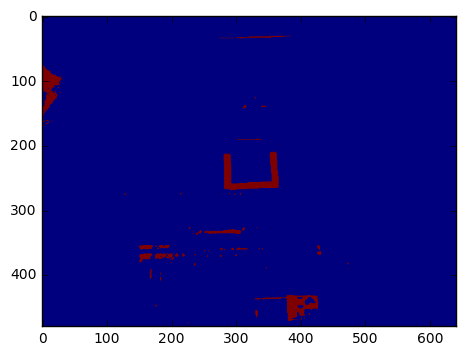

In [46]:
imgray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
plt.imshow(thresh)

Well, that looks pretty decent, optimally we could clean up some of those smaller sections but let's see what contours gives us. 

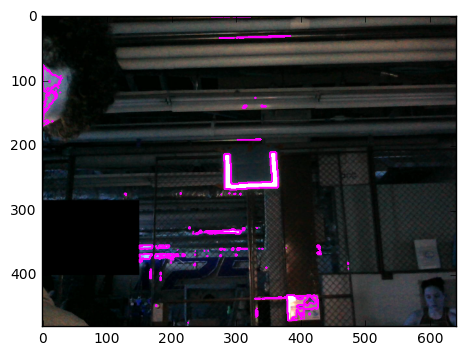

In [47]:
contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
allContours = image.copy()
cv2.drawContours(allContours,contours,-1,(255,0,255),2)
plt.imshow(allContours)

Ok, there's some magic in that `drawContours` function, you don't need to worry about it. I mostly use it for debugging. Clearly, however, there's a lot of contours, we need to do some pruning. 

A solid heuristic is to check the largest target first. In our case, and in many others, this is all you may need to do. But, in the case of potentially multiple contours that are similar in size you can do a couple simple tests. The easiest of these is to test the aspect ratio. We're going to skip that for now since it's less vision and more just general programming. 

For the time being we will use the imaginary function `rateContours` that will return a higher number the more likely the contour is the correct one. Basically, this is our heuristic function. 

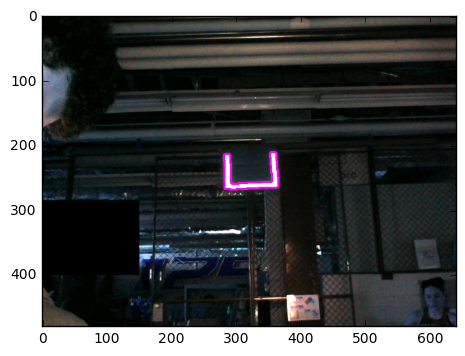

In [48]:
def rateContours(r):
    return cv2.contourArea(r)

contours = sorted(contours, key=rateContours, reverse=True)
oneContour = image.copy()
cv2.drawContours(oneContour,contours,0,(255,0,255),2)
plt.imshow(oneContour)


## Determine Pose Change

Ok, what do I mean by pose change? I mean how the robot has to change to align itself to the target. For our purposes we're going to say it needs to line up the bench grinder and we don't worry about speed. Warning, this requires math. But it's simple, so stick with me. 

One general rule is to assume that the center of the camera is at 0 for where you'll aim. Effectively what this means is that shooting and your camera might want to be aligned along the center axis of your robot. You can compensate for it, but why make your life harder? 

Ok, to do this you need two constants - the horizontal field of view of the camera (FOV) and the horizontal width (in pixels) of the image (WIDTH). 

From there we'll define a pair of functions (one of which really should be in OpenCV already)

In [57]:
# Extracts the centroid from a contour, seriously, why isn't this built in?
def centroid(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)

# Map pixels to degrees
def getAngle(centroid, FOV, WIDTH):
    slope = float(FOV)/WIDTH
    intercept = -FOV/2.0
    angle = (centroid[0]*slope)+intercept
    return angle


Yeah, that's it. `getAngle` will return the angle you need to turn to. 